In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
lion_king_data = processed_data[(processed_data['movie_name'] == 'The Lion King') & (processed_data['year'] == '1994')]

In [2]:
before_dropping_na = lion_king_data['are_you_an_only_child'].value_counts()
lion_king_data = lion_king_data[lion_king_data['are_you_an_only_child'] != -1.0] # remove NA values
after_dropping_na = lion_king_data['are_you_an_only_child'].value_counts() 

print("Before dropping NA values:")
print(before_dropping_na)
print("\nAfter dropping NA values:")
print(after_dropping_na)

Before dropping NA values:
are_you_an_only_child
 0.0    894
 1.0    177
-1.0     26
Name: count, dtype: int64

After dropping NA values:
are_you_an_only_child
0.0    894
1.0    177
Name: count, dtype: int64


In [3]:
only_child_group = lion_king_data[lion_king_data['are_you_an_only_child'] == 1]
not_only_child_group = lion_king_data[lion_king_data['are_you_an_only_child'] == 0]

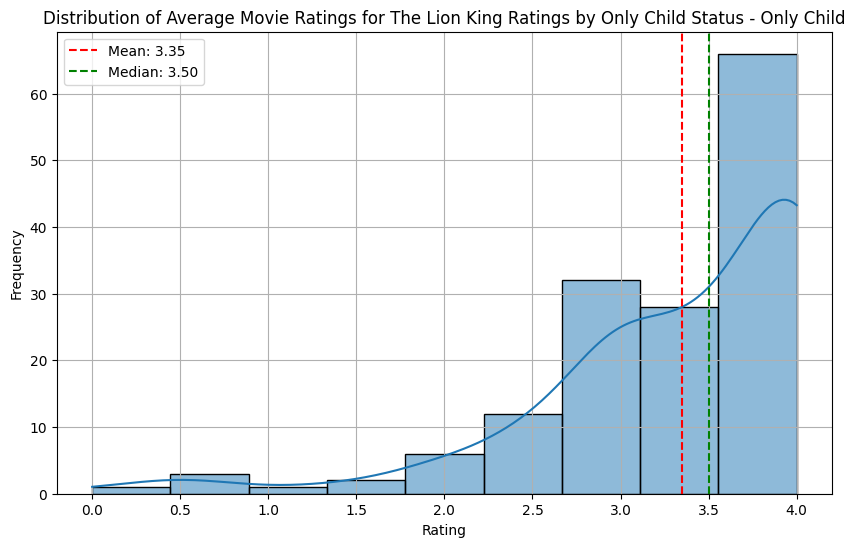

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [4]:
gf.plot_distrubtion(only_child_group,
    name='The Lion King Ratings by Only Child Status - Only Child',
    y='rating',
    bins=9)

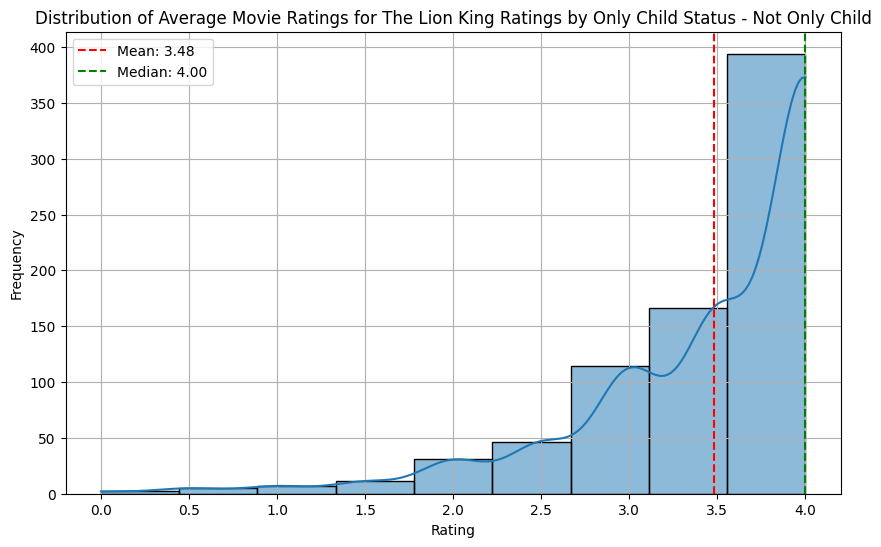

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [5]:
gf.plot_distrubtion(not_only_child_group,
    name='The Lion King Ratings by Only Child Status - Not Only Child',
    y='rating',
    bins=9)

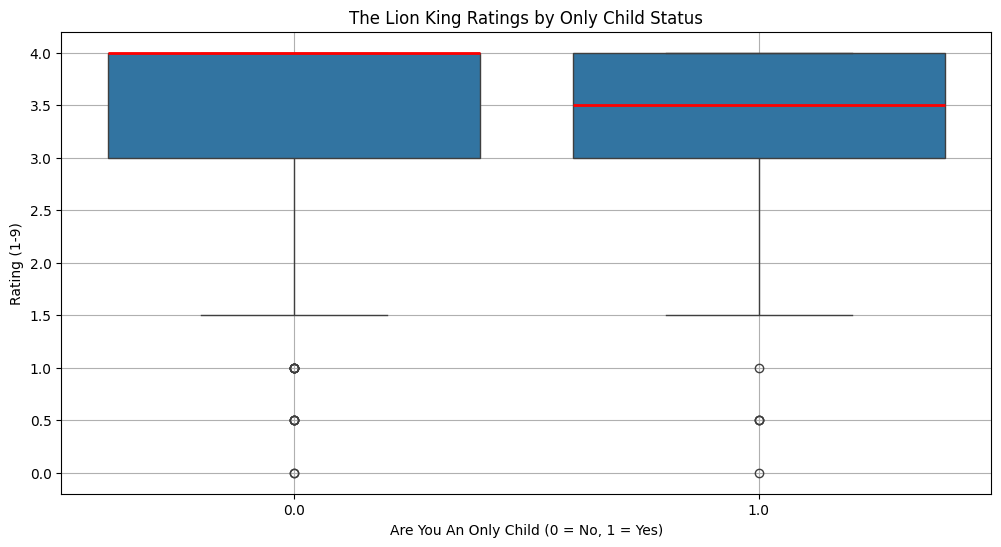

<module 'matplotlib.pyplot' from '/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/movie-ratings-replication/my_project_env/lib/python3.13/site-packages/matplotlib/pyplot.py'>

In [6]:
gf.plot_boxplot(lion_king_data,
    title='The Lion King Ratings by Only Child Status',
    x='are_you_an_only_child',
    y='rating',
    xlabel ='Are You An Only Child (0 = No, 1 = Yes)',
    ylabel ='Rating (1-9)')